In [1]:
%load_ext autoreload
%autoreload 2
import litebird_sim as lbs
import numpy as np
import healpy as hp
import sbm
import logging
import toml
from pathlib import Path
import matplotlib.pyplot as plt
#from rich import print
logging.basicConfig(level=logging.WARNING)

In [2]:
# Load your Imo in litebird_sim

CONFIG_PATH = Path.home() / ".config" / "litebird_imo"
CONFIG_FILE_PATH = CONFIG_PATH / "imo.toml"
tomlinfo = toml.load(CONFIG_FILE_PATH)
flatfile_location = tomlinfo["repositories"][0]["location"]

imo_version = "v2"
imo = lbs.Imo(flatfile_location=flatfile_location)

In [3]:
fg_models = ["pysm_dust_0", "pysm_synch_0"]
sim = lbs.Simulation(random_seed=None)
mdim = 2
cmap = sbm.get_cmap()
#sim_channels = sbm.channel_list[:2] # Only two channels

sim_channels = sbm.channel_list
np.random.seed(123)

gamma_T_list = [1.019031716035418, 1.0426732981603957] # [dust, synch] for top
gamma_B_list = [1.0130868422025714, 1.048540936388469] # [dust, synch] for bottom

channel = "M1-140"
detector_name = "001_003_030_00A_" + channel[3:] + "_T"
telescope = channel[0] + "FT"
print(f"Running channel: {channel}")

sf = sbm.ScanFields.load_det(f"{channel}/{detector_name}")

Mbsparams = lbs.MbsParameters(
    make_cmb=False,
    cmb_r=0.0,
    make_fg=True,
    seed_cmb=1234,
    fg_models=fg_models,
    gaussian_smooth=True,
    bandpass_int=False,
    nside=sf.nside,
    units="K_CMB",
    maps_in_ecliptic=False,
)
ch_info = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info",
    imo=imo,
)
mbs = lbs.Mbs(
    simulation=sim,
    parameters=Mbsparams,
    channel_list=ch_info,
)
map_info = mbs.run_all()[0]
fgs = mbs.generate_fg()[0]
dust = fgs[fg_models[0]][0][0]
synch = fgs[fg_models[1]][0][0]
components = [dust, synch]

temp = map_info[channel][0]
pol = map_info[channel][1] + 1j * map_info[channel][2]

signal_field = sbm.SignalFields.bandpass_mismatch_field(
    sf,
    mdim,
    pol,
    gamma_T_list,
    gamma_B_list,
    components,
)
output_map = sf.map_make(signal_field, show_eq=False)
residual = output_map - map_info[channel]

Running channel: M1-140


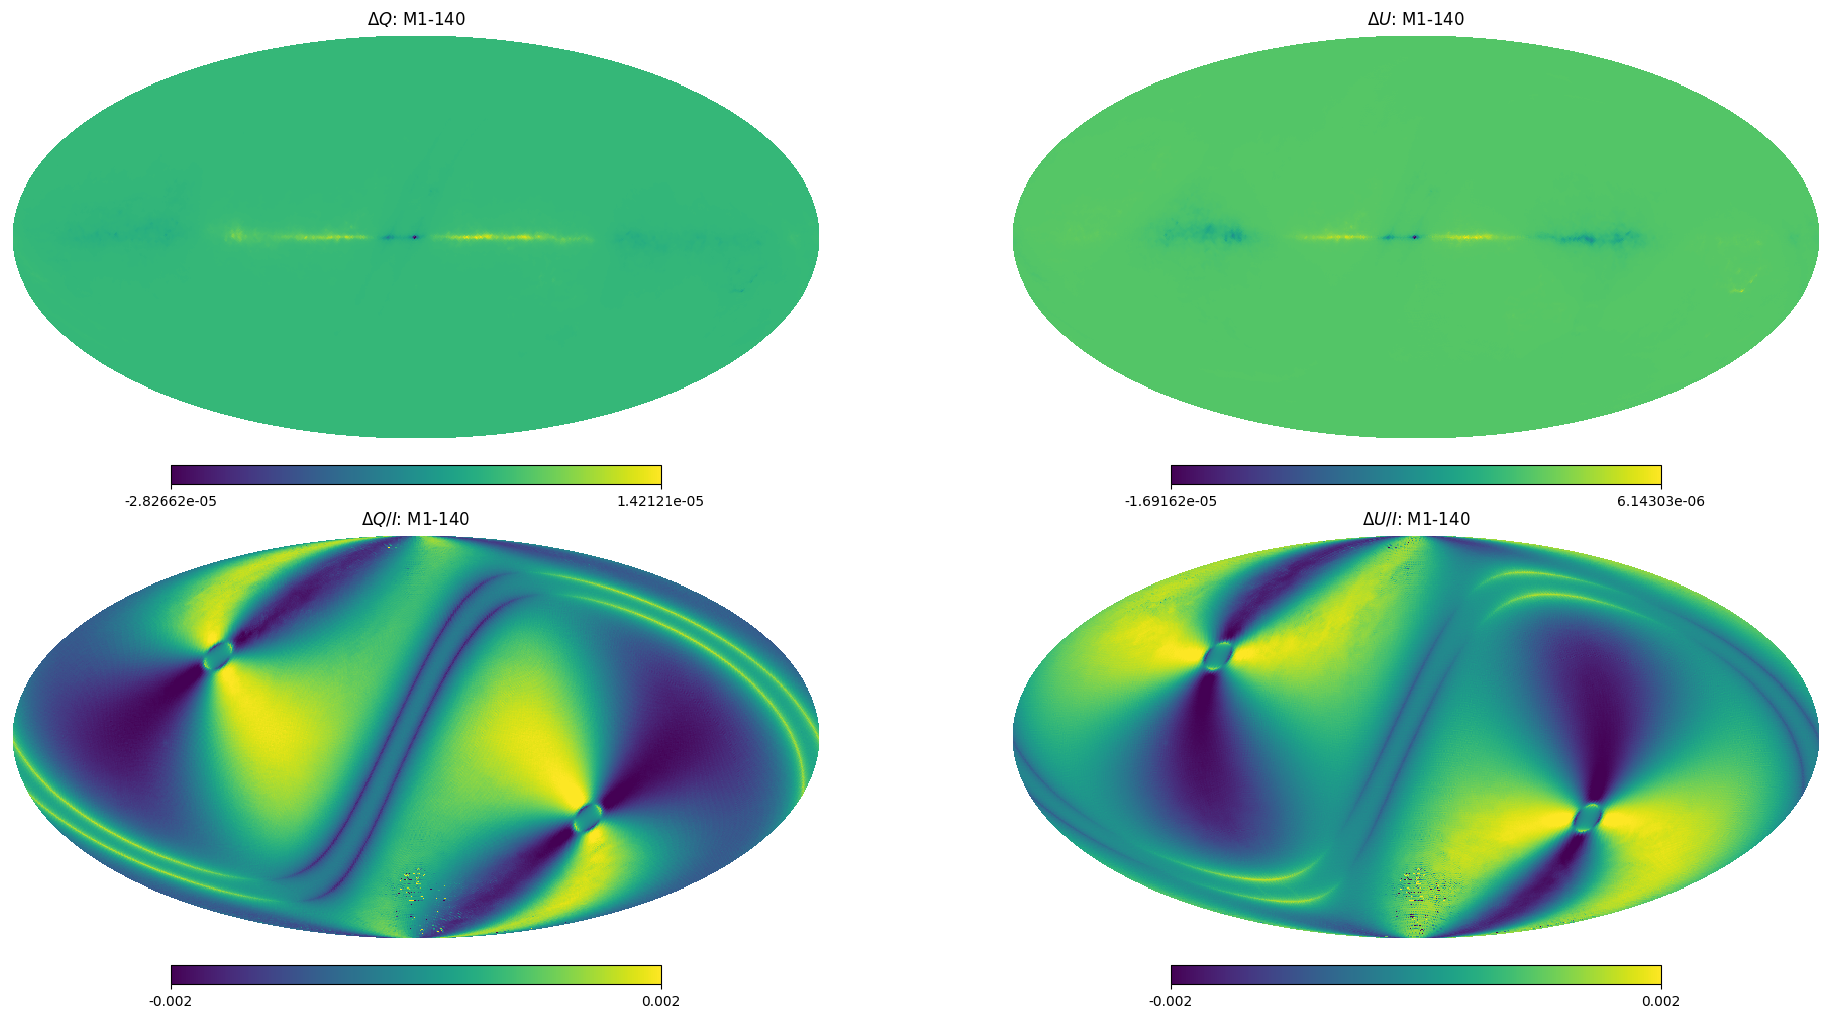

In [4]:
val = 0.002
plt.figure(figsize=(20, 10))
hp.mollview(residual[1], title=f"$\Delta Q$: {channel}", sub=(2, 2, 1))
hp.mollview(residual[2], title=f"$\Delta U$: {channel}", sub=(2, 2, 2))
hp.mollview(residual[1]/temp, title=f"$\Delta Q/I$: {channel}", sub=(2, 2, 3), min=-val, max=val)
hp.mollview(residual[2]/temp, title=f"$\Delta U/I$: {channel}", sub=(2, 2, 4), min=-val, max=val)

In [42]:
# Load LiteBIRD channel from SBM's channel list
channel = sbm.channel_list[-1]
# Define the telescope
telescope = channel[0] + "FT"
print("Channel: ", channel)

# Load the channel info
ch_info = lbs.FreqChannelInfo.from_imo(
    url=f"/releases/{imo_version}/satellite/{telescope}/{channel}/channel_info", imo=imo
)
detectors = ch_info.detector_names
print("No. of dets: ", len(detectors))

Channel:  H3-402
No. of dets:  338


In [43]:
config = sbm.Configlation(imo, channel)
config.mdim = 2
#config.spin_n_basis = [0, 2, -2]
#config.spin_m_basis = [0, 0, 0]
config.parallel = True
config.nside = 128
config.xlink_threshold = 1.0
config.use_hwp = False
syst = sbm.Systematics()

gamma_T = np.random.normal(loc=1.0, scale=1, size=[len(detectors), len(fg_models)])
gamma_B = np.random.normal(loc=1.0, scale=0.0, size=[len(detectors), len(fg_models)])
syst.set_bandpass_mismatch(
    detectors,
    gamma_T,
    gamma_B,
    components
)

In [44]:
output, inputmap = sbm.sim_bandpass_mismatch(
    config,
    syst,
    Mbsparams,
)

Processing H3-402: 100%|██████████| 338/338 [00:06<00:00, 53.10it/s] 


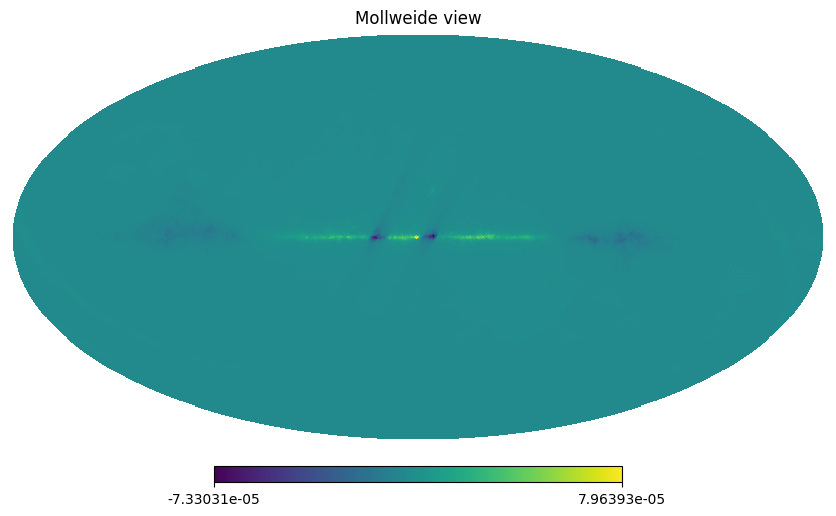

In [45]:
hp.mollview(output[1]-inputmap[1])